<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/01_GNN_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks for Molecular Representation: Tutorial

## Table of Contents
1. [Setup and Installation](#setup-and-installation)
2. [Introduction](#introduction)
3. [Theoretical Background: Molecules as Graphs](#theoretical-background-molecules-as-graphs)
4. [Implementing Molecular Graph Representations](#implementing-molecular-graph-representations)
5. [PyTorch Geometric for Molecular Graphs](#pytorch-geometric-for-molecular-graphs)
6. [Working with Molecular Datasets](#working-with-molecular-datasets)
7. [Visualizing Molecular Graphs](#visualizing-molecular-graphs)

## 1. Setup and Installation <a name="setup-and-installation"></a>

First, we'll install the required libraries. We'll need:
- **RDKit**: For molecular manipulation and cheminformatics
- **PyTorch Geometric**: For graph neural network implementations
- **Matplotlib & Seaborn**: For visualization
- **NetworkX**: For graph manipulation and visualization

In [1]:
#@title install required libraries
!pip install -q rdkit
!pip install -q torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00


Now let's import the libraries we'll need throughout this tutorial:


In [2]:
#@title Import required libraries
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit for molecular handling
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

# PyTorch and PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import to_networkx

# NetworkX for graph visualization
import networkx as nx

# Set plotting style
sns.set_context("notebook", font_scale=1.5)
sns.set_palette("Set2")

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Introduction <a name="introduction"></a>
Historically, the biggest difficulty for machine learning with molecules was the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input.

GNNs are specific layers that input a graph and output a graph. You can find reviews of GNNs in Dwivedi *et al.*{cite}`dwivedi2020benchmarking`, Bronstein *et al.*{cite}`bronstein2017geometric`, and  Wu *et al.*{cite}`wu2020comprehensive`. GNNs can be used for everything from coarse-grained molecular dynamics {cite}`li2020graph` to predicting NMR chemical shifts {cite}`yang2020predicting` to modeling dynamics of solids {cite}`xie2019graph`. Before we dive too deep into them, we must first understand how a graph is represented in a computer and how molecules are converted into graphs.

You can find an interactive introductory article on graphs and graph neural networks at [distill.pub](https://distill.pub/2021/gnn-intro/) {cite}`sanchez-lengeling2021a`. Most current research in GNNs is done with specialized deep learning libraries for graphs. The most common are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), [Deep Graph library](https://www.dgl.ai/), [DIG](https://github.com/divelab/DIG), [Spektral](https://graphneural.network/), and [TensorFlow GNNS](https://github.com/tensorflow/gnn).


### Learning Objectives

By the end of this tutorial, you will be able to:
- **Understand** the theoretical foundations of graph representations for molecules
- **Implement** conversion from molecular structures to graph data structures
- **Distinguish** between graph, node, and edge features and their chemical significance
- **Work with** PyTorch Geometric for molecular graph manipulation
- **Visualize** molecular graphs and their learned representations




## 3. Theoretical Background: Molecules as Graphs <a name="theoretical-background-molecules-as-graphs"></a>


### What is a Graph?

A graph G is defined by a set of nodes (vertices) V and edges E. In the context of molecules:
- **Nodes** represent atoms
- **Edges** represent bonds between atoms

Mathematically, we can represent a graph in several ways:
1. **Adjacency Matrix**: A matrix E where e_ij = 1 if nodes i and j are connected
2. **Node Feature Matrix**: A matrix V where each row represents the features of a node
3. **Edge Feature Matrix**: A tensor where each entry e_ij represents features of the connection between nodes i and j

### Representing Molecules as Graphs

Let's consider a simple molecule: methanol (CH₃OH).


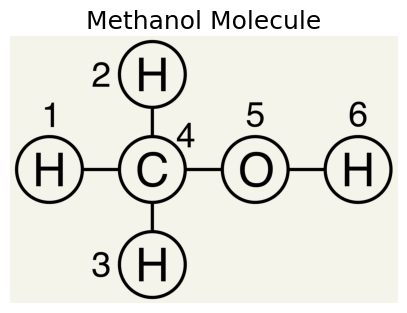

In [3]:
# Download methanol image for visualization
!wget -q https://github.com/whitead/dmol-book/blob/main/dl/methanol.jpg?raw=true -O methanol.jpg

# Display the molecule
from PIL import Image
img = Image.open('methanol.jpg')
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.axis('off')
plt.title('Methanol Molecule')
plt.show()

Let's see how a graph can be constructed from a molecule. Consider methanol, shown in the figure.

When representing methanol as a graph:
1. We have 6 nodes (atoms): 1 carbon (C), 1 oxygen (O), and 4 hydrogens (H)
2. We have 5 edges (bonds): 1 C-O, 1 O-H, and 3 C-H bonds


#### Node Features

For each atom (node), we need to define a feature vector. Commonly used atom features include:
- **Atom type** (usually one-hot encoded)
- **Formal charge**
- **Hybridization state**
- **Aromaticity**
- **Number of connected hydrogens**

For simplicity, let's start with just atom type using one-hot encoding:





In [4]:
# Define a simple mapping of atoms to indices
atom_mapping = {'H': 0, 'O': 1, 'C': 2}

# Let's visualize the node feature matrix for methanol
# Atom order:  H, H, H, C, O, H
node_features = np.zeros((6, 3))  # 6 atoms, 3 possible atom types
node_features[0, 0] = 1  # H
node_features[1, 0] = 1  # H
node_features[2, 0] = 1  # H
node_features[3, 2] = 1  # C
node_features[4, 1] = 1  # O
node_features[5, 0] = 1  # H

print("Node Feature Matrix (Rows: Atoms, Columns: Atom Types):")
node_df = pd.DataFrame(node_features,
                      index=['1', '2', '3', '4', '5', '6'],
                      columns=['H', 'O', 'C'])
display(node_df)

Node Feature Matrix (Rows: Atoms, Columns: Atom Types):


,H,O,C
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
5,0.0,1.0,0.0
6,1.0,0.0,0.0


#### Adjacency Matrix

The adjacency matrix represents which atoms are bonded to each other:

In [5]:
# Let's create the adjacency matrix for methanol
# Atom order: H, H, H, C, O, H (indexed from 0 to 5)
adjacency = np.zeros((6, 6))

# Define bonds: C-O, O-H and C-H bonds
bonds = [(0, 3),  # C-H1
         (1, 3),  # C-H2
         (2, 3),  # C-H3
         (3, 4),  # C-O
         (4, 5)]  # O-H4

# Fill the adjacency matrix (undirected graph, so matrix is symmetric)
for i, j in bonds:
    adjacency[i, j] = 1
    adjacency[j, i] = 1  # Symmetric because bonds are undirected

print("Adjacency Matrix (1 indicates a bond between atoms):")
adj_df = pd.DataFrame(adjacency,
                      index=['1', '2', '3', '4', '5', '6'],
                      columns=['1', '2', '3', '4', '5', '6'])
display(adj_df)

Adjacency Matrix (1 indicates a bond between atoms):


,1,2,3,4,5,6
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0,1.0
6,0.0,0.0,0.0,0.0,1.0,0.0


#### Edge Features

We can also define features for each bond (edge), such as:
- **Bond type** (single, double, triple, aromatic)
- **Bond length**
- **Bond angle**

For simplicity, we'll just use bond type as a feature:

In [6]:
# Create an edge feature tensor for methanol
# We'll use one-hot encoding for bond types: [single, double, triple, aromatic]
num_bonds = len(bonds)
edge_features = np.zeros((num_bonds, 4))  # 5 bonds, 4 possible bond types

# All bonds in methanol are single bonds (index 0)
edge_features[:, 0] = 1

print("Edge Feature Matrix (Rows: Bonds, Columns: Bond Types):")
edge_df = pd.DataFrame(edge_features,
                      index=['C-H1', 'C-H2', 'C-H3', 'C-O', 'O-H4'],
                      columns=['Single', 'Double', 'Triple', 'Aromatic'])
display(edge_df)

Edge Feature Matrix (Rows: Bonds, Columns: Bond Types):


,Single,Double,Triple,Aromatic
C-H1,1.0,0.0,0.0,0.0
C-H2,1.0,0.0,0.0,0.0
C-H3,1.0,0.0,0.0,0.0
C-O,1.0,0.0,0.0,0.0
O-H4,1.0,0.0,0.0,0.0


### Visualizing the Graph Representation

Let's visualize the methanol molecule as a graph:

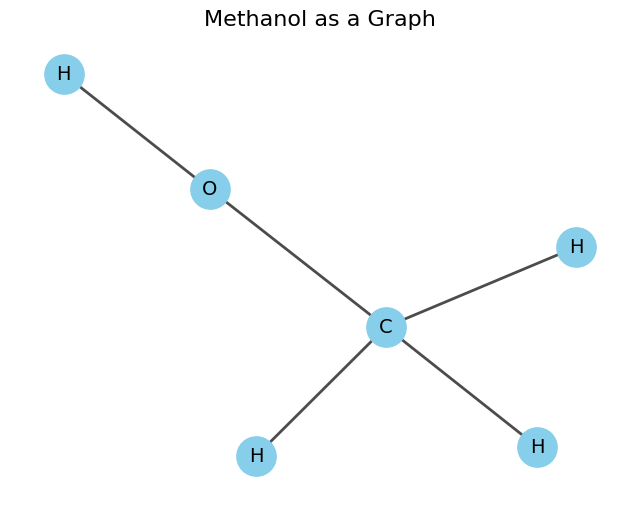

In [7]:
def visualize_molecular_graph(adjacency, node_labels):
    """Visualize a molecule as a graph."""
    G = nx.Graph()

    # Add nodes
    for i, label in enumerate(node_labels):
        G.add_node(i, label=label)

    # Add edges
    rows, cols = np.where(adjacency == 1)
    edges = zip(rows.tolist(), cols.tolist())
    for i, j in edges:
        if i < j:  # Add each edge only once
            G.add_edge(i, j)

    # Plot the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)  # Position nodes using spring layout

    # Draw nodes with labels
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
    nx.draw_networkx_labels(G, pos, labels={i: node_labels[i] for i in range(len(node_labels))}, font_size=14)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7)

    plt.axis('off')
    plt.title('Methanol as a Graph', fontsize=16)
    plt.show()

# Visualize methanol
atom_labels = [ 'H', 'H', 'H', 'C', 'O', 'H']
visualize_molecular_graph(adjacency, atom_labels)

### From Chemical Structure to Graph: The Complete Picture

Now let's put it all together to understand the flow from a chemical structure to a graph representation:

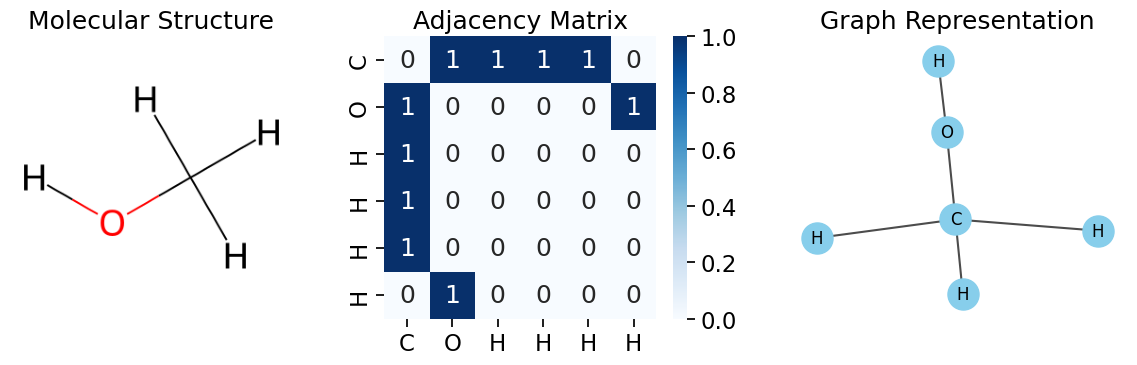

In [8]:
def show_molecule_to_graph_conversion(smiles):
    """Show the conversion from molecular structure to graph representation."""
    # Create RDKit molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)  # Add hydrogens

    # Draw the molecule
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecular Structure')

    # Get atom and bond information
    atoms = [a.GetSymbol() for a in mol.GetAtoms()]
    atom_indices = {a.GetIdx(): i for i, a in enumerate(mol.GetAtoms())}

    # Create adjacency matrix
    n_atoms = len(atoms)
    adj_matrix = np.zeros((n_atoms, n_atoms))

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1

    # Create node features (one-hot encoding of atom type)
    unique_atoms = sorted(set(atoms))
    atom_to_idx = {atom: i for i, atom in enumerate(unique_atoms)}

    node_features = np.zeros((n_atoms, len(unique_atoms)))
    for i, atom in enumerate(atoms):
        node_features[i, atom_to_idx[atom]] = 1

    # Visualize adjacency matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(adj_matrix, cmap='Blues', annot=True, fmt='.0f',
                xticklabels=atoms, yticklabels=atoms)
    plt.title('Adjacency Matrix')

    # Visualize the graph
    plt.subplot(1, 3, 3)
    G = nx.Graph()

    # Add nodes
    for i, atom in enumerate(atoms):
        G.add_node(i, label=atom)

    # Add edges
    rows, cols = np.where(adj_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    for i, j in edges:
        if i < j:  # Add each edge only once
            G.add_edge(i, j)

    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
    nx.draw_networkx_labels(G, pos, labels={i: atoms[i] for i in range(len(atoms))}, font_size=12)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    plt.axis('off')
    plt.title('Graph Representation')

    plt.tight_layout()
    plt.show()

    return mol, adj_matrix, node_features, atoms

# Demonstrate with methanol
methanol_smiles = "CO"
mol, adj_matrix, node_features, atoms = show_molecule_to_graph_conversion(methanol_smiles)

### ✅ Checkpoint: Understanding Molecular Graphs

To reinforce your understanding, try answering these questions:

1. **Question**: What does each row in the node feature matrix represent?
   - **Answer**: Each row represents one atom in the molecule, with its features encoded.

2. **Question**: Why is the adjacency matrix symmetric for molecules?
   - **Answer**: Because chemical bonds are undirected (atoms are mutually bonded to each other).

3. **Question**: How would the graph representation change for a molecule with a double bond?
   - **Answer**: The edge feature for that bond would have a 1 in the position representing double bonds instead of single bonds.

## 4. Implementing Molecular Graph Representations <a name="implementing-molecular-graph-representations"></a>

Now, let's create a function to convert any molecule (represented as a SMILES string) into a graph representation:
1. **Identifying nodes**: Each atom becomes a node in our graph
2. **Creating node features**: We'll encode atom properties (element type, charge, etc.)
3. **Identifying edges**: Each chemical bond becomes an edge in our graph
4. **Creating edge features**: We'll encode bond properties (single, double, aromatic, etc.)

This conversion allows us to represent any molecular structure as a set of matrices that capture both the topology (connectivity) and the chemical properties of the molecule.

The function below performs this conversion:

In [9]:
def smiles_to_graph(smiles):
    """
    Convert a SMILES string to graph representation.

    Args:
        smiles (str): SMILES string of the molecule (e.g., "CCO" for ethanol)

    Returns:
        tuple:
            - node_features: Matrix where each row represents an atom's properties
            - adjacency: Matrix showing which atoms are connected by bonds
            - edge_features: Matrix containing properties of each bond
            - edge_indices: List of atom pairs connected by bonds
    """
    # Step 1: Parse the SMILES string using RDKit
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Step 2: Add hydrogen atoms explicitly
    # In SMILES, hydrogens are often implicit but we need them for complete graphs in this tutorial
    mol = Chem.AddHs(mol)

    # Step 3: Define bond type mapping (translates chemical bond types to indices)
    # This mapping helps us create one-hot encodings for different bond types
    bond_type_to_idx = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3,
    }

    # Step 4: Count the total number of atoms in the molecule
    n_atoms = mol.GetNumAtoms()

    # Step 5: Create node features matrix
    # We're using one-hot encoding for atom types (C, O, N, H, and "other")
    elements = ["C", "O", "N", "H", "Other"]
    node_features = np.zeros((n_atoms, len(elements)))

    # Step 6: Fill node features matrix with atom information
    for atom in mol.GetAtoms():
        idx = atom.GetIdx() # Get atom's position in the molecule
        symbol = atom.GetSymbol() # Get atom's chemical symbol

        # Convert atom element to one-hot encoding
        if symbol in elements:
            node_features[idx, elements.index(symbol)] = 1 # One-hot encode atom type
        else:
            # Mark as "other" if not in our element list
            node_features[idx, -1] = 1

    # Step 7: Initialize adjacency matrix and edge feature storage
    # Adjacency matrix shows which atoms are connected
    adjacency = np.zeros((n_atoms, n_atoms))
    edge_features = [] # Will store properties of each bond
    edge_indices = [] # Will store which atoms are connected

    # Step 8: Process each bond in the molecule
    for bond in mol.GetBonds():
        # Get the atoms connected by this bond
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()

        # Update adjacency matrix to show these atoms are connected
        # Both entries are 1 because chemical bonds are bidirectional (undirected graph)
        adjacency[begin_idx, end_idx] = 1
        adjacency[end_idx, begin_idx] = 1

        # Get bond type
        bond_type = bond.GetBondType()
        bond_feature = np.zeros(len(bond_type_to_idx))

        if bond_type in bond_type_to_idx:
            bond_feature[bond_type_to_idx[bond_type]] = 1
        else:
            print(f"Warning: Unknown bond type {bond_type}")

        # Add edge in both directions (undirected graph)
        edge_features.append(bond_feature)
        edge_indices.append((begin_idx, end_idx))

        edge_features.append(bond_feature)  # Same feature for the reverse direction
        edge_indices.append((end_idx, begin_idx))

    # Step 9: Convert edge features to numpy array for consistency
    if edge_features:
        edge_features = np.array(edge_features)
    else:
        edge_features = np.empty((0, len(bond_type_to_idx)))

    return node_features, adjacency, edge_features, edge_indices

# Let's test our function on several molecules
molecules = {
    "Methanol": "CO",
    "Ethanol": "CCO",
    "Benzene": "c1ccccc1",
    "Caffeine": "CN1C=NC2=C1C(=O)N(C)C(=O)N2C",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}

# Test with sample molecule (choose from Methanol, Ethanol, Benzene, Caffeine, and Aspirin)
sample_molecule="Methanol"
sample_features, sample_adj, sample_edge_features, sample_edge_indices = smiles_to_graph(molecules[sample_molecule])

print(f"{sample_molecule} Node Features:")
print(sample_features)
print(f" \n{sample_molecule} Adjacency Matrix:")
print(sample_adj)
print(f"\n{sample_molecule} Edge Features:")
print(sample_edge_features)

Methanol Node Features:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
 
Methanol Adjacency Matrix:
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]

Methanol Edge Features:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


Let's interpret what these matrices mean for methanol (CH₃OH):

**Node Features Matrix:**
- Each row represents one atom in the molecule
- The columns represent [C, O, N, H, Other]
- For example, row 3 has a 1 in the 4th position, indicating this is a hydrogen atom
- Row 1 has a 1 in the 1st position, indicating this is a carbon atom

**Adjacency Matrix:**
- This 6×6 matrix shows which atoms are bonded to each other
- Reading row 1 (carbon), we see 1s in positions 2, 3, 4, and 5, meaning the carbon is bonded to 3 hydrogen atoms and 1 oxygen atom
- This perfectly matches methanol's structure (CH₃OH)

**Edge Features:**
- Each row represents a bond in the molecule
- The columns represent [single, double, triple, aromatic]
- All rows have a 1 in the first position, indicating all bonds in methanol are single bonds

This representation captures both the structural connectivity and the chemical properties of methanol in a format that machine learning algorithms can process.

Let's analyze a more complex molecule to see the differences:

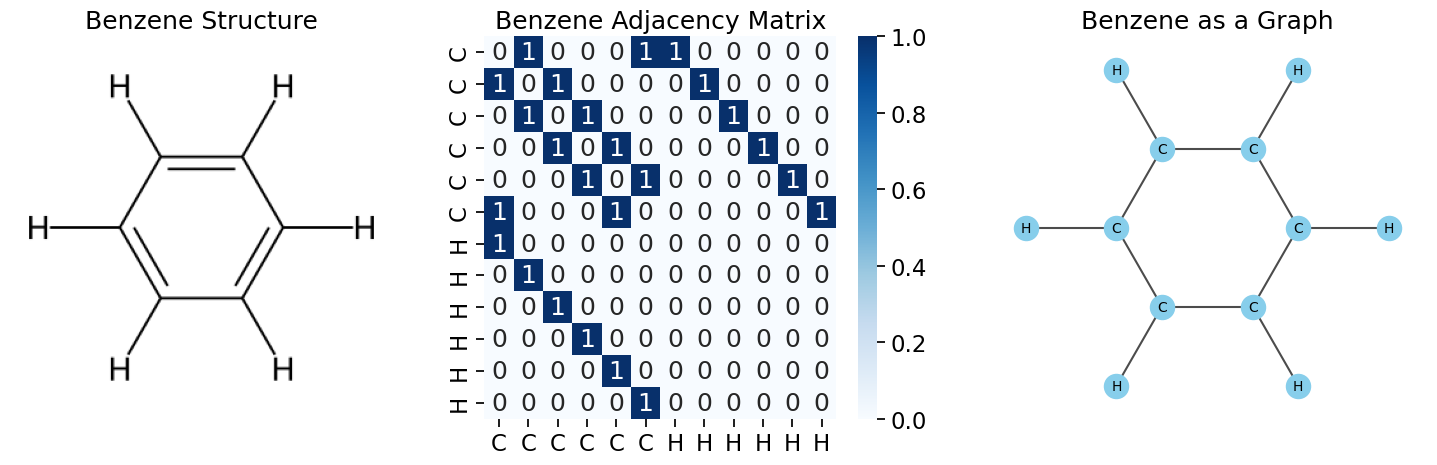

Benzene Edge Features (showing only a few):
Edge (0, 1): Aromatic bond
Edge (1, 0): Aromatic bond
Edge (1, 2): Aromatic bond
Edge (2, 1): Aromatic bond
Edge (2, 3): Aromatic bond
Edge (3, 2): Aromatic bond


In [10]:
# Let's analyze benzene in more detail
benzene_features, benzene_adj, benzene_edge_features, benzene_edge_indices = smiles_to_graph(molecules["Benzene"])

# Visualize benzene
benzene_mol = Chem.MolFromSmiles(molecules["Benzene"])
benzene_mol = Chem.AddHs(benzene_mol)
AllChem.Compute2DCoords(benzene_mol)
benzene_img = Draw.MolToImage(benzene_mol, size=(300, 300))

plt.figure(figsize=(15, 5))

# Molecular structure
plt.subplot(1, 3, 1)
plt.imshow(benzene_img)
plt.axis('off')
plt.title('Benzene Structure')

# Adjacency matrix
plt.subplot(1, 3, 2)
atom_symbols = [atom.GetSymbol() for atom in benzene_mol.GetAtoms()]
sns.heatmap(benzene_adj, cmap='Blues', annot=True, fmt='.0f',
            xticklabels=atom_symbols, yticklabels=atom_symbols)
plt.title('Benzene Adjacency Matrix')

# Graph representation
plt.subplot(1, 3, 3)
G = nx.Graph()
for i, symbol in enumerate(atom_symbols):
    G.add_node(i, label=symbol)

# Add edges
rows, cols = np.where(benzene_adj == 1)
edges = zip(rows.tolist(), cols.tolist())
for i, j in edges:
    if i < j:  # Add each edge only once
        G.add_edge(i, j)

# Get the 2D coordinates from RDKit
pos = {}
for i, atom in enumerate(benzene_mol.GetAtoms()):
    pos[i] = benzene_mol.GetConformer().GetAtomPosition(i)
    pos[i] = (pos[i].x, pos[i].y)

nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=300)
nx.draw_networkx_labels(G, pos, labels={i: atom_symbols[i] for i in range(len(atom_symbols))}, font_size=10)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
plt.axis('off')
plt.title('Benzene as a Graph')

plt.tight_layout()
plt.show()

# Examine aromatic bonds in benzene
benzene_features, benzene_adj, benzene_edge_features, benzene_edge_indices = smiles_to_graph(molecules["Benzene"])

print("Benzene Edge Features (showing only a few):")
for i, (edge, feature) in enumerate(zip(benzene_edge_indices[:6], benzene_edge_features[:6])):
    bond_type = "Single" if feature[0] == 1 else "Double" if feature[1] == 1 else "Triple" if feature[2] == 1 else "Aromatic"
    print(f"Edge {edge}: {bond_type} bond")


### Feature Engineering for Molecular Graphs

The simple representation above uses only atom type and bond type, but real-world applications often need more sophisticated features. While the basic representation captures molecular structure, chemists know that many properties depend on more detailed atomic and bond attributes. For example:

- An atom's **hybridization** affects its geometry and reactivity
- **Aromaticity** drastically changes chemical behavior
- **Ring structures** influence molecular rigidity and reactivity

The enhanced function below incorporates these important chemical concepts into our graph representation:

In [11]:
def advanced_smiles_to_graph(smiles):
    """
    Convert a SMILES string to graph representation with advanced features.

    Args:
        smiles (str): SMILES string of the molecule

    Returns:
        tuple: Node features, adjacency matrix, edge features, edge indices
    """
    # Create RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Add hydrogens to explicit representation
    mol = Chem.AddHs(mol)

    # Map bond types to indices
    bond_type_to_idx = {
        Chem.rdchem.BondType.SINGLE: 0,
        Chem.rdchem.BondType.DOUBLE: 1,
        Chem.rdchem.BondType.TRIPLE: 2,
        Chem.rdchem.BondType.AROMATIC: 3,
    }

    # Get the number of atoms
    n_atoms = mol.GetNumAtoms()

    # Advanced node features
    node_features = []
    for atom in mol.GetAtoms():
        # Basic properties
        atom_type = atom.GetSymbol()
        atomic_num = atom.GetAtomicNum()
        formal_charge = atom.GetFormalCharge()
        hybridization = atom.GetHybridization()
        is_aromatic = int(atom.GetIsAromatic())
        is_in_ring = int(atom.IsInRing())

        # Create one-hot encoding for atom type (C, O, N, H, F, P, S, Cl, Br, I, or other)
        atom_types = ['C', 'O', 'N', 'H', 'F', 'P', 'S', 'Cl', 'Br', 'I']
        atom_type_onehot = [1 if atom_type == t else 0 for t in atom_types]
        if atom_type not in atom_types:
            atom_type_onehot.append(1)  # "Other" category
        else:
            atom_type_onehot.append(0)

        # One-hot for hybridization
        hybridization_types = [
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3
        ]
        hybridization_onehot = [1 if hybridization == h else 0 for h in hybridization_types]
        if hybridization not in hybridization_types:
            hybridization_onehot.append(1)  # "Other" hybridization
        else:
            hybridization_onehot.append(0)

        # Combine all features
        features = atom_type_onehot + [
            formal_charge,
            is_aromatic,
            is_in_ring,
            atom.GetDegree(),         # Number of directly bonded neighbors
            atom.GetTotalNumHs(),     # Total number of Hs (explicit and implicit)
            atom.GetNumRadicalElectrons()  # Number of radical electrons
        ] + hybridization_onehot

        node_features.append(features)

    # Convert to numpy array
    node_features = np.array(node_features)

    # Create adjacency matrix and edge features
    adjacency = np.zeros((n_atoms, n_atoms))
    edge_features = []
    edge_indices = []

    for bond in mol.GetBonds():
        # Get the atoms in the bond
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()

        # Update adjacency matrix (symmetric)
        adjacency[begin_idx, end_idx] = 1
        adjacency[end_idx, begin_idx] = 1

        # Advanced bond features
        bond_type = bond.GetBondType()
        bond_type_onehot = np.zeros(len(bond_type_to_idx))
        if bond_type in bond_type_to_idx:
            bond_type_onehot[bond_type_to_idx[bond_type]] = 1

        is_conjugated = int(bond.GetIsConjugated())
        is_in_ring = int(bond.IsInRing())

        # Combine all bond features
        features = np.concatenate([bond_type_onehot, [is_conjugated, is_in_ring]])

        # Add edge in both directions (undirected graph)
        edge_features.append(features)
        edge_indices.append((begin_idx, end_idx))

        edge_features.append(features)  # Same feature for the reverse direction
        edge_indices.append((end_idx, begin_idx))

    # Convert edge features to numpy array
    if edge_features:
        edge_features = np.array(edge_features)
    else:
        edge_features = np.empty((0, len(bond_type_to_idx) + 2))  # +2 for conjugation and ring

    return node_features, adjacency, edge_features, edge_indices

# Test with sample molecule (choose from Methanol, Ethanol, Benzene, Caffeine, and Aspirin)

sample_molecule="Aspirin"
aspirin_features, aspirin_adj, aspirin_edge_features, aspirin_edge_indices = advanced_smiles_to_graph(molecules[sample_molecule])

print(f"{sample_molecule} has {aspirin_features.shape[0]} atoms with {aspirin_features.shape[1]} features per atom")
print(f"{sample_molecule} has {len(aspirin_edge_indices) // 2} bonds with {aspirin_edge_features.shape[1]} features per bond")

# Show the first atom's features
print("\nFeatures for the first atom:")
aspirin_mol = Chem.MolFromSmiles(molecules[sample_molecule])
aspirin_mol = Chem.AddHs(aspirin_mol)
first_atom = aspirin_mol.GetAtomWithIdx(0)
print(f"Atom type: {first_atom.GetSymbol()}")
print(f"Feature vector: {aspirin_features[0]}")

Aspirin has 21 atoms with 21 features per atom
Aspirin has 21 bonds with 6 features per bond

Features for the first atom:
Atom type: C
Feature vector: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0]


### Interpreting Advanced Features for Aspirin

The advanced representation for aspirin includes much richer chemical information:

1. **Atom Features Now Include:**
   - Element type (C, O, etc.)
   - Formal charge (important for reaction sites)
   - Hybridization state (sp, sp², sp³)
   - Aromaticity (critical for the benzene ring in aspirin)
   - Ring membership
   - Atomic degree (number of bonds, related to steric hindrance)
   - Hydrogen count (important for H-bonding)

2. **Bond Features Now Include:**
   - Bond type (single, double, etc.)
   - Conjugation (important for electron delocalization)
   - Ring membership (bonds within rings behave differently)

For the first atom (carbon), we see its complete chemical signature encoded in the feature vector. This rich representation allows machine learning models to recognize important pharmacophores and chemical patterns that determine aspirin's properties.

### ✅ Checkpoint Exercise: Implement Graph Representation for Ethanol

Now it's your turn to apply what you've learned:

### Exercise
1- Write code to create and visualize the graph representation for ethanol (CCO)

## 5. PyTorch Geometric for Molecular Graphs <a name="pytorch-geometric-for-molecular-graphs"></a>

Now that we understand the fundamentals of graph representation for molecules, let's implement this using PyTorch Geometric (PyG), a library specifically designed for graph neural networks. While our basic graph representation works well, specialized libraries like PyTorch Geometric (PyG) offer optimized data structures for graph machine learning. There are two main differences to understand:

1. **Edge Representation:** Instead of using an adjacency matrix, PyG uses a more efficient "COO" (COOrdinate) format that only stores the non-zero entries.

2. **Tensor Format:** All data is stored in PyTorch tensors rather than NumPy arrays, allowing GPU acceleration.

### Creating a PyG Data Object

PyTorch Geometric represents a graph using the `Data` class with several key attributes:
- `x`: Node feature matrix
- `edge_index`: Graph connectivity in COO format
- `edge_attr`: Edge feature matrix
- `y`: Target values (for prediction tasks)

The function below converts our chemical graph into PyG's specialized format. Let's convert our molecular graph representation to a PyG Data object:



### How to create a graph in PyTorch Geometric

In [13]:
def smiles_to_pyg(smiles):
    """
    Convert a SMILES string to a PyTorch Geometric Data object.

    Args:
        smiles (str): SMILES string of the molecule

    Returns:
        torch_geometric.data.Data: PyG Data object
    """
    # Get the graph representation
    node_features, adjacency, edge_features, edge_indices = advanced_smiles_to_graph(smiles)

    # Convert node features to PyTorch tensor
    x = torch.tensor(node_features, dtype=torch.float)

    # Convert edge indices to PyTorch tensor in COO format
    # PyG expects edge_index to be of shape [2, num_edges]
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()

    # Convert edge features to PyTorch tensor
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, smiles=smiles)

    return data

# Let's test our function with aspirin
aspirin_pyg = smiles_to_pyg(molecules["Aspirin"])
print("PyG Data Object for Aspirin:")
print(aspirin_pyg)
print("\nNode Features Shape:", aspirin_pyg.x.shape)
print("Edge Index Shape:", aspirin_pyg.edge_index.shape)
print("Edge Features Shape:", aspirin_pyg.edge_attr.shape)

PyG Data Object for Aspirin:
Data(x=[21, 21], edge_index=[2, 42], edge_attr=[42, 6], smiles='CC(=O)OC1=CC=CC=C1C(=O)O')

Node Features Shape: torch.Size([21, 21])
Edge Index Shape: torch.Size([2, 42])
Edge Features Shape: torch.Size([42, 6])


### Understanding PyG Data Format

Let's take a closer look at the PyG Data object structure, particularly the edge_index format which might be unfamiliar:

Methanol as a PyG Data object:
Data(x=[6, 21], edge_index=[2, 10], edge_attr=[10, 6], smiles='CO')

Edge Index Tensor:
[[0 1 0 2 0 3 0 4 1 5]
 [1 0 2 0 3 0 4 0 5 1]]


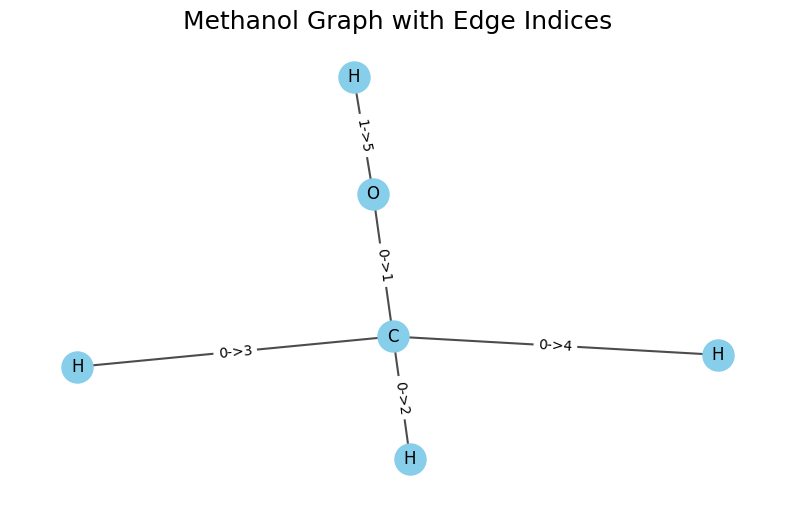


COO (Coordinate) Format Explanation:
In PyG, edge_index uses a sparse representation called COO format
- First row: source nodes (sender nodes)
- Second row: target nodes (receiver nodes)
- Each column represents one directed edge
For undirected graphs like molecules, each edge appears twice (in both directions)


In [14]:
# Let's use a simpler molecule (Methanol) to understand the edge_index format
methanol_pyg = smiles_to_pyg(molecules["Methanol"])

print("Methanol as a PyG Data object:")
print(methanol_pyg)

# Extracting components
edge_index = methanol_pyg.edge_index.numpy()
x = methanol_pyg.x.numpy()

# Display the edge_index tensor
print("\nEdge Index Tensor:")
print(edge_index)

# Visualize what this means
methanol_mol = Chem.MolFromSmiles(molecules["Methanol"])
methanol_mol = Chem.AddHs(methanol_mol)
atom_symbols = [atom.GetSymbol() for atom in methanol_mol.GetAtoms()]

# Create visual representation of edges
plt.figure(figsize=(10, 6))
G = nx.Graph()

for i, symbol in enumerate(atom_symbols):
    G.add_node(i, label=symbol)

# Add edges from edge_index
for i in range(edge_index.shape[1]):
    source, target = edge_index[0, i], edge_index[1, i]
    # Only add each edge once (PyG has both directions)
    if source < target:
        G.add_edge(source, target)

pos = nx.spring_layout(G, seed=42)

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)
nx.draw_networkx_labels(G, pos, labels={i: atom_symbols[i] for i in range(len(atom_symbols))}, font_size=12)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)

# Add edge indices
edge_labels = {}
for i in range(edge_index.shape[1]):
    source, target = edge_index[0, i], edge_index[1, i]
    if source < target:  # Only label one direction
        edge_labels[(source, target)] = f"{source}->{target}"

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Methanol Graph with Edge Indices")
plt.axis("off")
plt.show()

# Explain COO format
print("\nCOO (Coordinate) Format Explanation:")
print("In PyG, edge_index uses a sparse representation called COO format")
print("- First row: source nodes (sender nodes)")
print("- Second row: target nodes (receiver nodes)")
print("- Each column represents one directed edge")
print("For undirected graphs like molecules, each edge appears twice (in both directions)")

## 6. Working with Molecular Datasets <a name="working-with-molecular-datasets"></a>

PyTorch Geometric provides easy access to various molecular datasets through its `MoleculeNet` class. These datasets are commonly used benchmarks for molecular property prediction.


Available MoleculeNet Datasets:
- ESOL
- FreeSolv
- Lipophilicity
- PCBA
- MUV
- HIV
- BACE
- BBBP
- Tox21
- ToxCast
- SIDER
- ClinTox


Processing...
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/dataset.py:169: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  warnings.warn("Found floating-point labels while calling "



Loaded ESOL dataset with 1128 molecules
Node features: 9
Task type: Classification

Sample from ESOL dataset:
Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])

Available properties:
- edge_attr: torch.Size([68, 3])
- y: torch.Size([1, 1])
- smiles: OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O 
- x: torch.Size([32, 9])
- edge_index: torch.Size([2, 68])


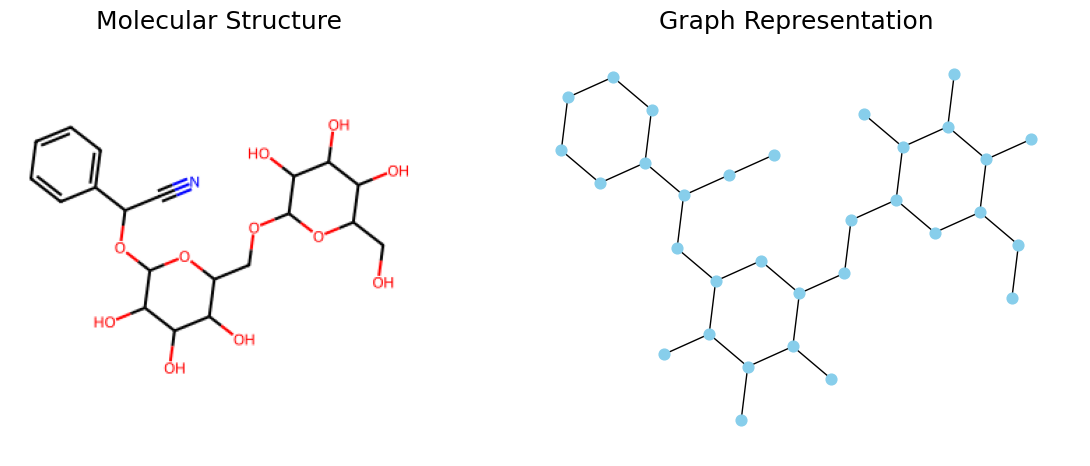


Target property (solubility): -0.7700


In [15]:
# List available datasets in MoleculeNet
available_datasets = [
    "ESOL", "FreeSolv", "Lipophilicity", "PCBA", "MUV", "HIV",
    "BACE", "BBBP", "Tox21", "ToxCast", "SIDER", "ClinTox"
]

print("Available MoleculeNet Datasets:")
for dataset in available_datasets:
    print(f"- {dataset}")

# Let's load the ESOL dataset (water solubility)
esol_dataset = MoleculeNet(root='./data', name='ESOL')

print(f"\nLoaded ESOL dataset with {len(esol_dataset)} molecules")
print(f"Node features: {esol_dataset.num_features}")
print(f"Task type: {'Classification' if esol_dataset.num_classes > 1 else 'Regression'}")

# Let's examine a sample from the dataset
sample = esol_dataset[0]
print("\nSample from ESOL dataset:")
print(sample)

# Check what properties are available
print("\nAvailable properties:")
for key in sample.keys():
    print(f"- {key}: {getattr(sample, key).shape if hasattr(getattr(sample, key), 'shape') else getattr(sample, key)}")

# Visualize the molecule
sample_mol = Chem.MolFromSmiles(sample.smiles)
sample_img = Draw.MolToImage(sample_mol, size=(300, 300))
AllChem.Compute2DCoords(sample_mol)


plt.figure(figsize=(12, 5))

# Show molecular structure
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.axis('off')
plt.title('Molecular Structure')

# Visualize as a graph
plt.subplot(1, 2, 2)
G = to_networkx(sample, to_undirected=True)
# Get the 2D coordinates from RDKit
pos = {}
for i, atom in enumerate(sample_mol.GetAtoms()):
    pos[i] = sample_mol.GetConformer().GetAtomPosition(i)
    pos[i] = (pos[i].x, pos[i].y)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=60)
plt.title('Graph Representation')

plt.tight_layout()
plt.show()

# Display target property (solubility)
print(f"\nTarget property (solubility): {sample.y.item():.4f}")

## 7. Visualizing Molecular Graphs <a name="visualizing-molecular-graphs"></a>

Visualization is crucial for understanding and interpreting molecular graphs. Let's explore different visualization techniques:

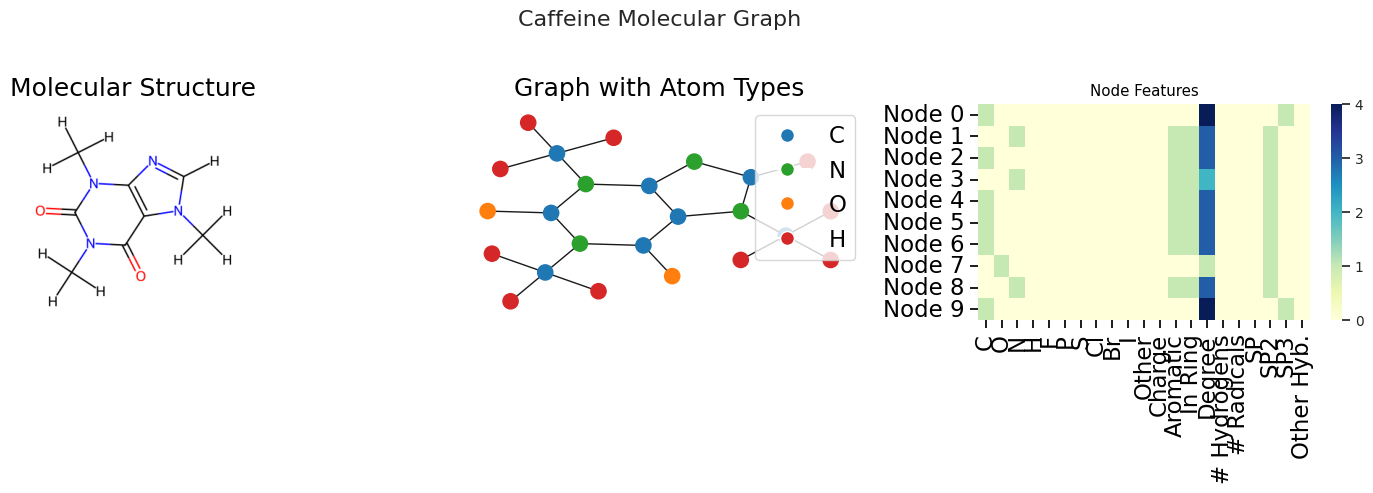

In [16]:
pyg_molecules = {name: smiles_to_pyg(smiles) for name, smiles in molecules.items()}

def visualize_molecular_graph_with_features(data, mol=None, title="Molecular Graph"):
    """
    Visualize a molecular graph with node features highlighted.

    Args:
        data: PyG Data object
        mol: RDKit molecule (optional)
        title: Plot title
    """
    if mol is None and hasattr(data, 'smiles'):
        mol = Chem.MolFromSmiles(data.smiles)
        # Add hydrogens to explicit representation
        mol = Chem.AddHs(mol)

    plt.figure(figsize=(15, 5))

    # 1. RDKit molecular structure
    if mol is not None:
        plt.subplot(1, 3, 1)
        # Add hydrogens to explicit representation
        mol = Chem.AddHs(mol)
        img = Draw.MolToImage(mol, size=(300, 300))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Molecular Structure')

    # 2. NetworkX graph visualization
    plt.subplot(1, 3, 2)

    G = to_networkx(data, to_undirected=True)

    AllChem.Compute2DCoords(mol)
    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, pos[i].y)

    # Color nodes based on atom type (first 5 features in our representation)
    node_colors = []
    legend_elements = []
    atom_types = ['C', 'O', 'N', 'H', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other']
    colors = plt.cm.tab10(np.linspace(0, 1, len(atom_types)))

    for node_idx, node_data in G.nodes(data=True):
        # Get the node features
        node_features = data.x[node_idx].numpy()
        # Determine the atom type (assumes one-hot encoding in first features)
        atom_type_idx = np.argmax(node_features[:len(atom_types)])
        if atom_type_idx < len(atom_types):
            node_colors.append(colors[atom_type_idx])
            # Add to legend if not already added
            if atom_types[atom_type_idx] not in [e.get_label() for e in legend_elements]:
                legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                                 markerfacecolor=colors[atom_type_idx],
                                                 markersize=10, label=atom_types[atom_type_idx]))

    # Draw graph
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=120)
    plt.legend(handles=legend_elements, loc='upper right')
    plt.title('Graph with Atom Types')

    # 3. Feature heatmap for a subset of nodes
    plt.subplot(1, 3, 3)
    # Select up to 10 nodes to display features
    num_nodes_to_show = min(10, data.x.shape[0])
    sns.set(font_scale=0.9)
    feature_names = ['C', 'O', 'N', 'H', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other',
                     'Charge', 'Aromatic', 'In Ring', 'Degree', '# Hydrogens', '# Radicals',
                     'SP', 'SP2', 'SP3', 'Other Hyb.']

    # Show features for the first few nodes
    node_features = data.x[:num_nodes_to_show, :len(feature_names)].numpy()
    sns.heatmap(node_features, cmap='YlGnBu',
                xticklabels=feature_names,
                yticklabels=[f"Node {i}" for i in range(num_nodes_to_show)])
    plt.title('Node Features')
    plt.tight_layout()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualize caffeine from our dataset
caffeine_data = pyg_molecules["Caffeine"]
caffeine_mol = Chem.MolFromSmiles(molecules["Caffeine"])
visualize_molecular_graph_with_features(caffeine_data, caffeine_mol, "Caffeine Molecular Graph")

### Visualizing Different Molecular Features

Let's explore how various molecular features are represented in the graph:

<ipython-input-17-0f4f5be53433>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nodes = nx.draw_networkx_nodes(G, pos, node_color=node_values, cmap=plt.cm.get_cmap(cmap),


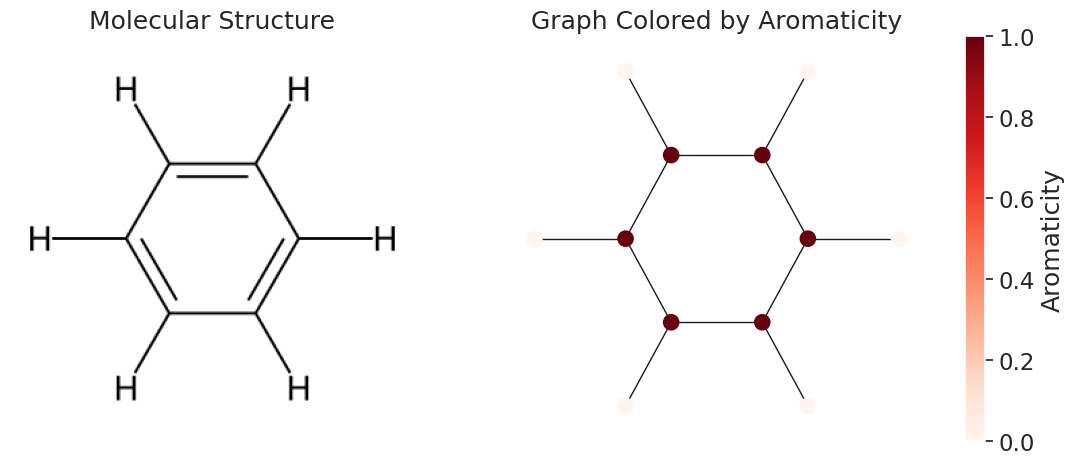

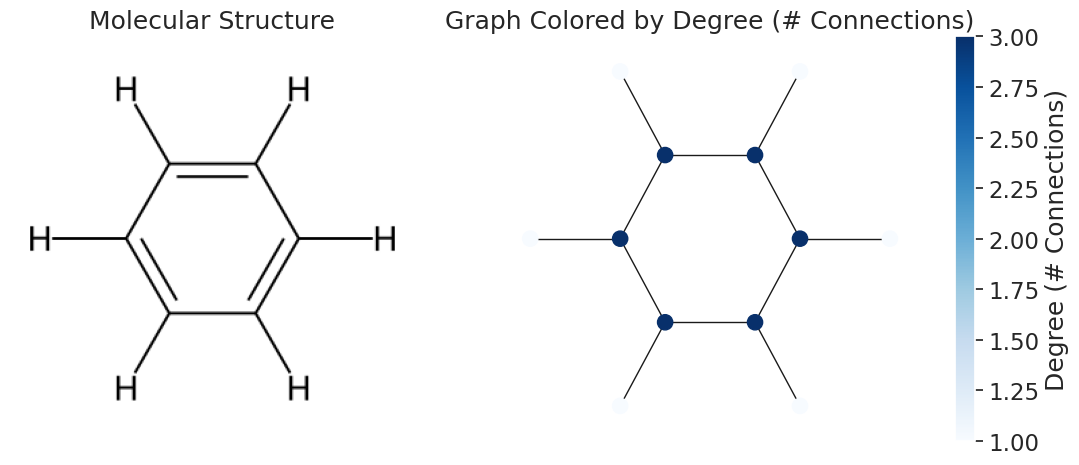

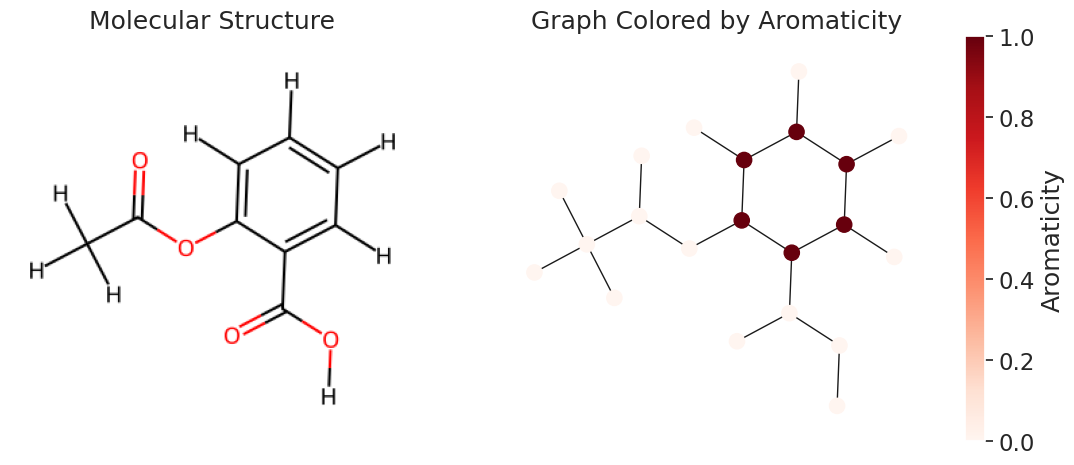

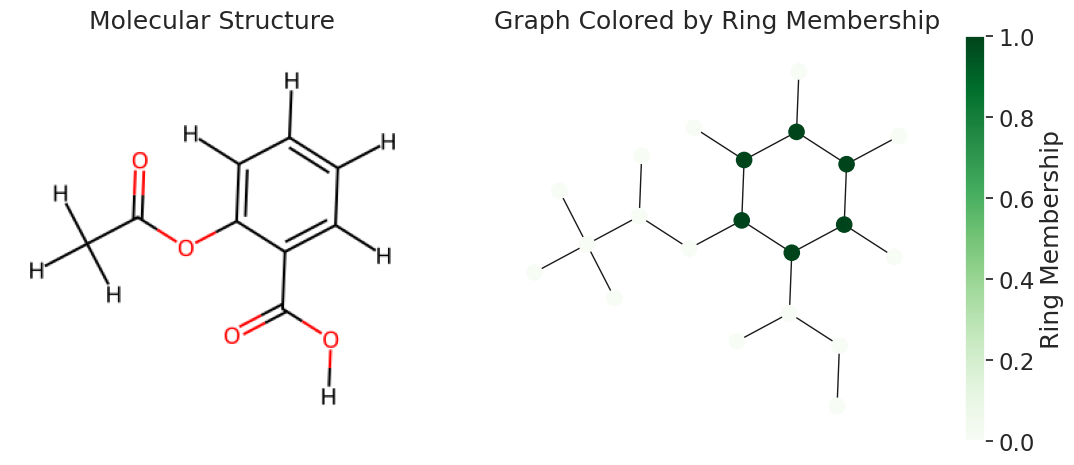

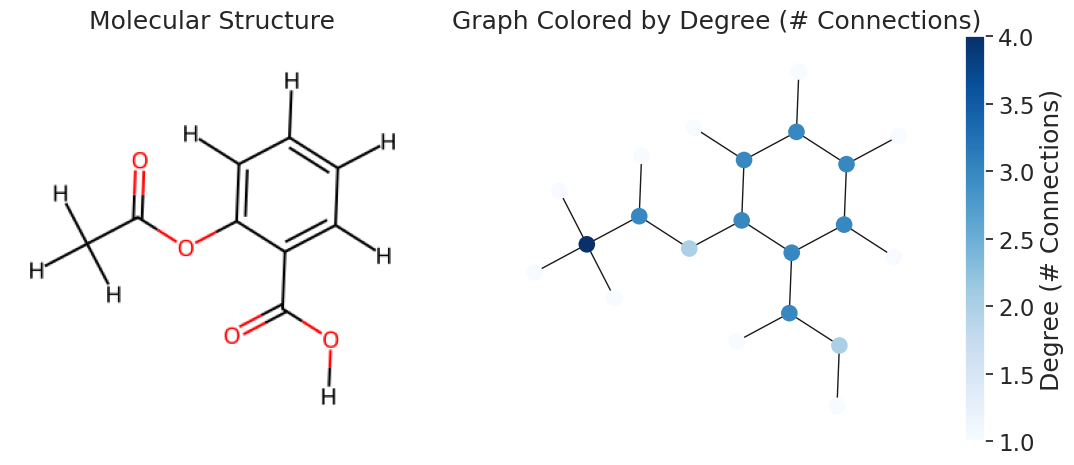

In [17]:
def visualize_graph_property(data, mol, property_idx, property_name, cmap='viridis'):
    """
    Visualize a specific molecular graph property.

    Args:
        data: PyG Data object
        mol: RDKit molecule
        property_idx: Index of the property in the feature vector
        property_name: Name of the property for display
        cmap: Colormap to use
    """
    sns.set(font_scale=1.5)
    plt.figure(figsize=(12, 5))

    # 1. RDKit molecular structure
    # Add hydrogens to explicit representation
    mol = Chem.AddHs(mol)
    plt.subplot(1, 2, 1)
    img = Draw.MolToImage(mol, size=(300, 300))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Molecular Structure')

    # 2. Graph colored by property
    plt.subplot(1, 2, 2)
    G = to_networkx(data, to_undirected=True)

    AllChem.Compute2DCoords(mol)

    G = to_networkx(data, to_undirected=True)
    # Get the 2D coordinates from RDKit
    pos = {}
    for i, atom in enumerate(mol.GetAtoms()):
        pos[i] = mol.GetConformer().GetAtomPosition(i)
        pos[i] = (pos[i].x, pos[i].y)

    # Get property values for each node
    node_values = [data.x[node_idx, property_idx].item() for node_idx in G.nodes()]

    # Draw the graph with nodes colored by property
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_values, cmap=plt.cm.get_cmap(cmap),
                                  node_size=120, vmin=min(node_values), vmax=max(node_values))
    nx.draw_networkx_edges(G, pos)

    # Add colorbar
    plt.colorbar(nodes, label=property_name)
    plt.title(f'Graph Colored by {property_name}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Let's visualize different properties for benzene
benzene_data = pyg_molecules["Benzene"]
benzene_mol = Chem.MolFromSmiles(molecules["Benzene"])

# Visualize aromaticity
visualize_graph_property(benzene_data, benzene_mol, 12, "Aromaticity", cmap='Reds')

# Visualize node degree (number of connections)
visualize_graph_property(benzene_data, benzene_mol, 14, "Degree (# Connections)", cmap='Blues')

# Compare with aspirin for more variety
aspirin_data = pyg_molecules["Aspirin"]
aspirin_mol = Chem.MolFromSmiles(molecules["Aspirin"])

# Visualize aromaticity in aspirin
visualize_graph_property(aspirin_data, aspirin_mol, 12, "Aromaticity", cmap='Reds')

# Visualize ring membership in aspirin
visualize_graph_property(aspirin_data, aspirin_mol, 13, "Ring Membership", cmap='Greens')

# Visualize node degree (number of connections) in aspirin
visualize_graph_property(aspirin_data, aspirin_mol, 14, "Degree (# Connections)", cmap='Blues')